In [12]:
import dgl # huggingface 같은 라이브러리
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from stgraph_trainer.datasets import *
from stgraph_trainer.trainers import RNNTrainer
from stgraph_trainer.utils import save_figure_predict
from stgraph_trainer.utils import matplotlib_plot_font
from stgraph_trainer.models import STGCN_WAVE
from stgraph_trainer.models import GRU, LSTM
from stgraph_trainer.utils import compute_metrics

import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from math import ceil
import warnings
warnings.filterwarnings('ignore')

print(os.getcwd())

matplotlib_plot_font()
device = torch.device("cpu")

/Users/jeonjunhwi/문서/Projects/Master_GNN/Code


In [13]:
def seq_data(data,sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(data) - sequence_length):
        x_seq.append(data[i:i+sequence_length])
        y_seq.append(data[i+sequence_length])
        # print(y_seq)
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)

def evaluate_metric(model, data_iter):
    model.eval()
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            #y = y.cpu().numpy().reshape(-1)
            y_pred = model(x).view(len(x), -1).cpu().numpy()#.reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / y).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        MAPE = np.array(mape).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, MAPE, RMSE
    
def seed_everything(seed = 42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'Seed set = {seed}')
    
seed_everything()

Seed set = 42


2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~ 2021-06-29 ~ 2021-07-27
make subplot
2
2020-05-01 ~ 2021-03-27 ~

<Figure size 1800x1080 with 0 Axes>

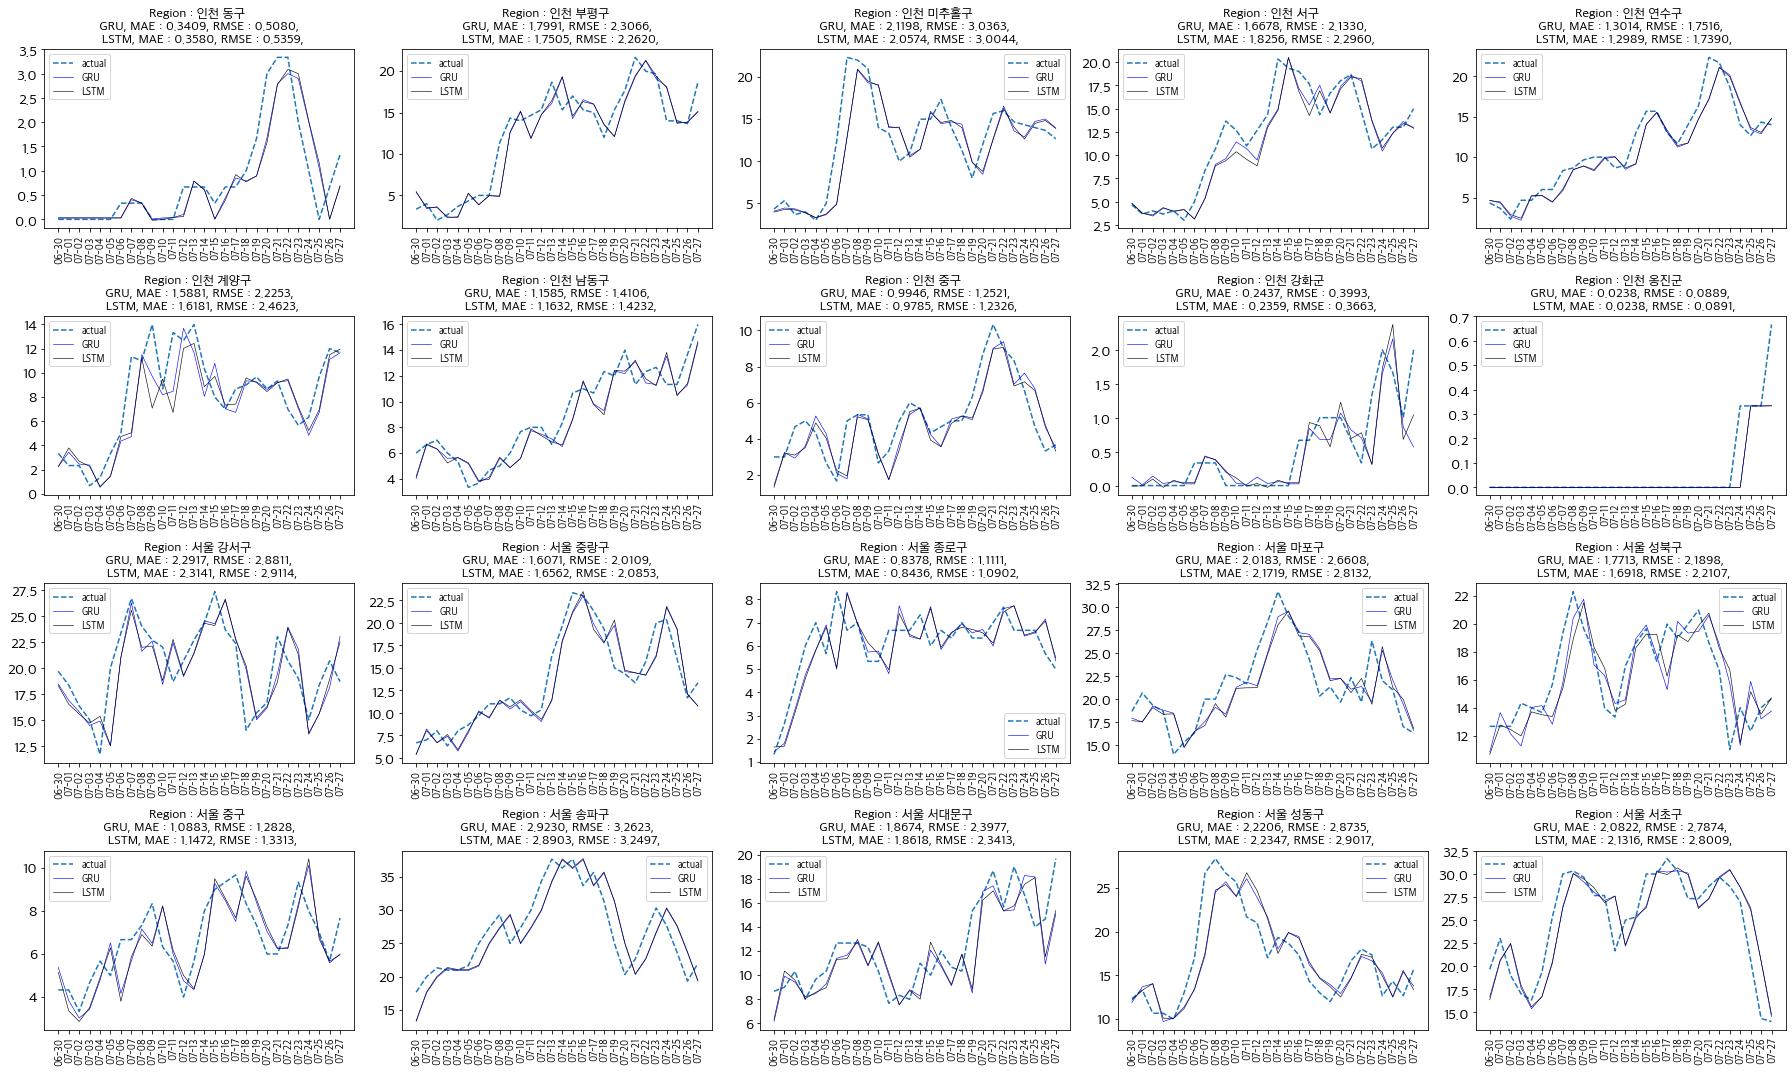

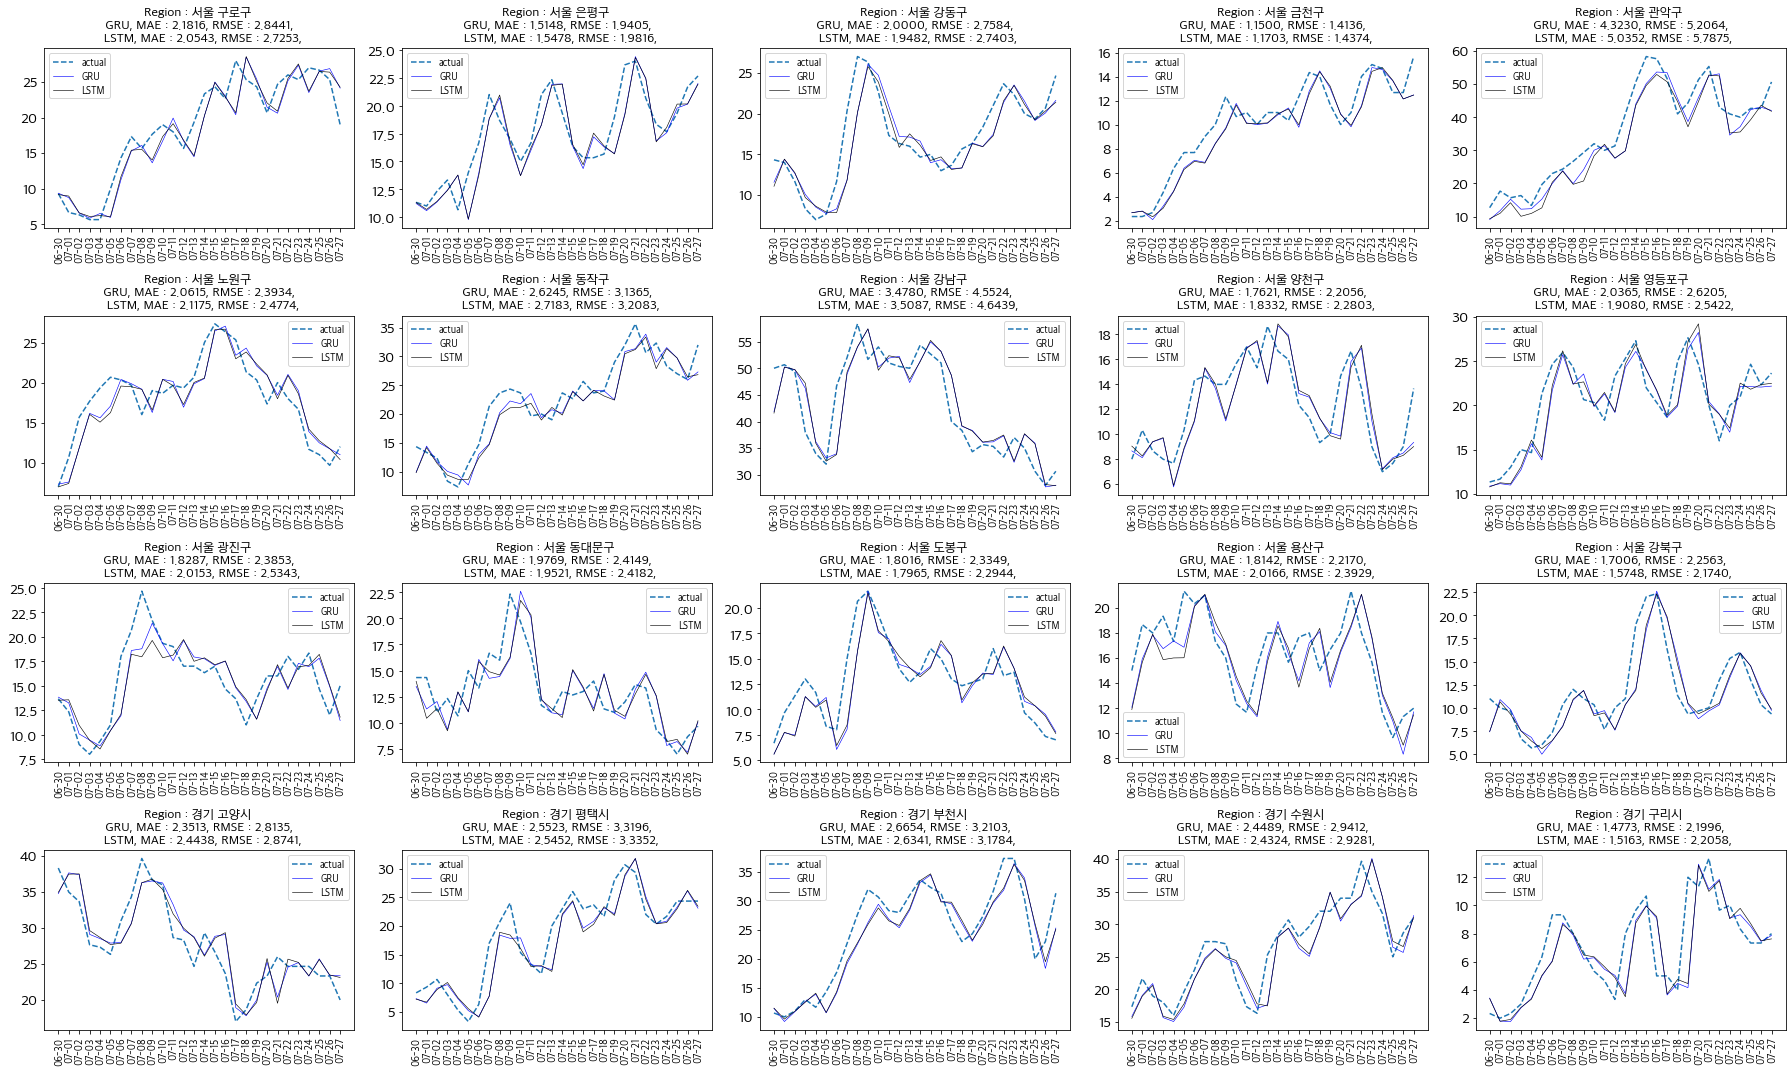

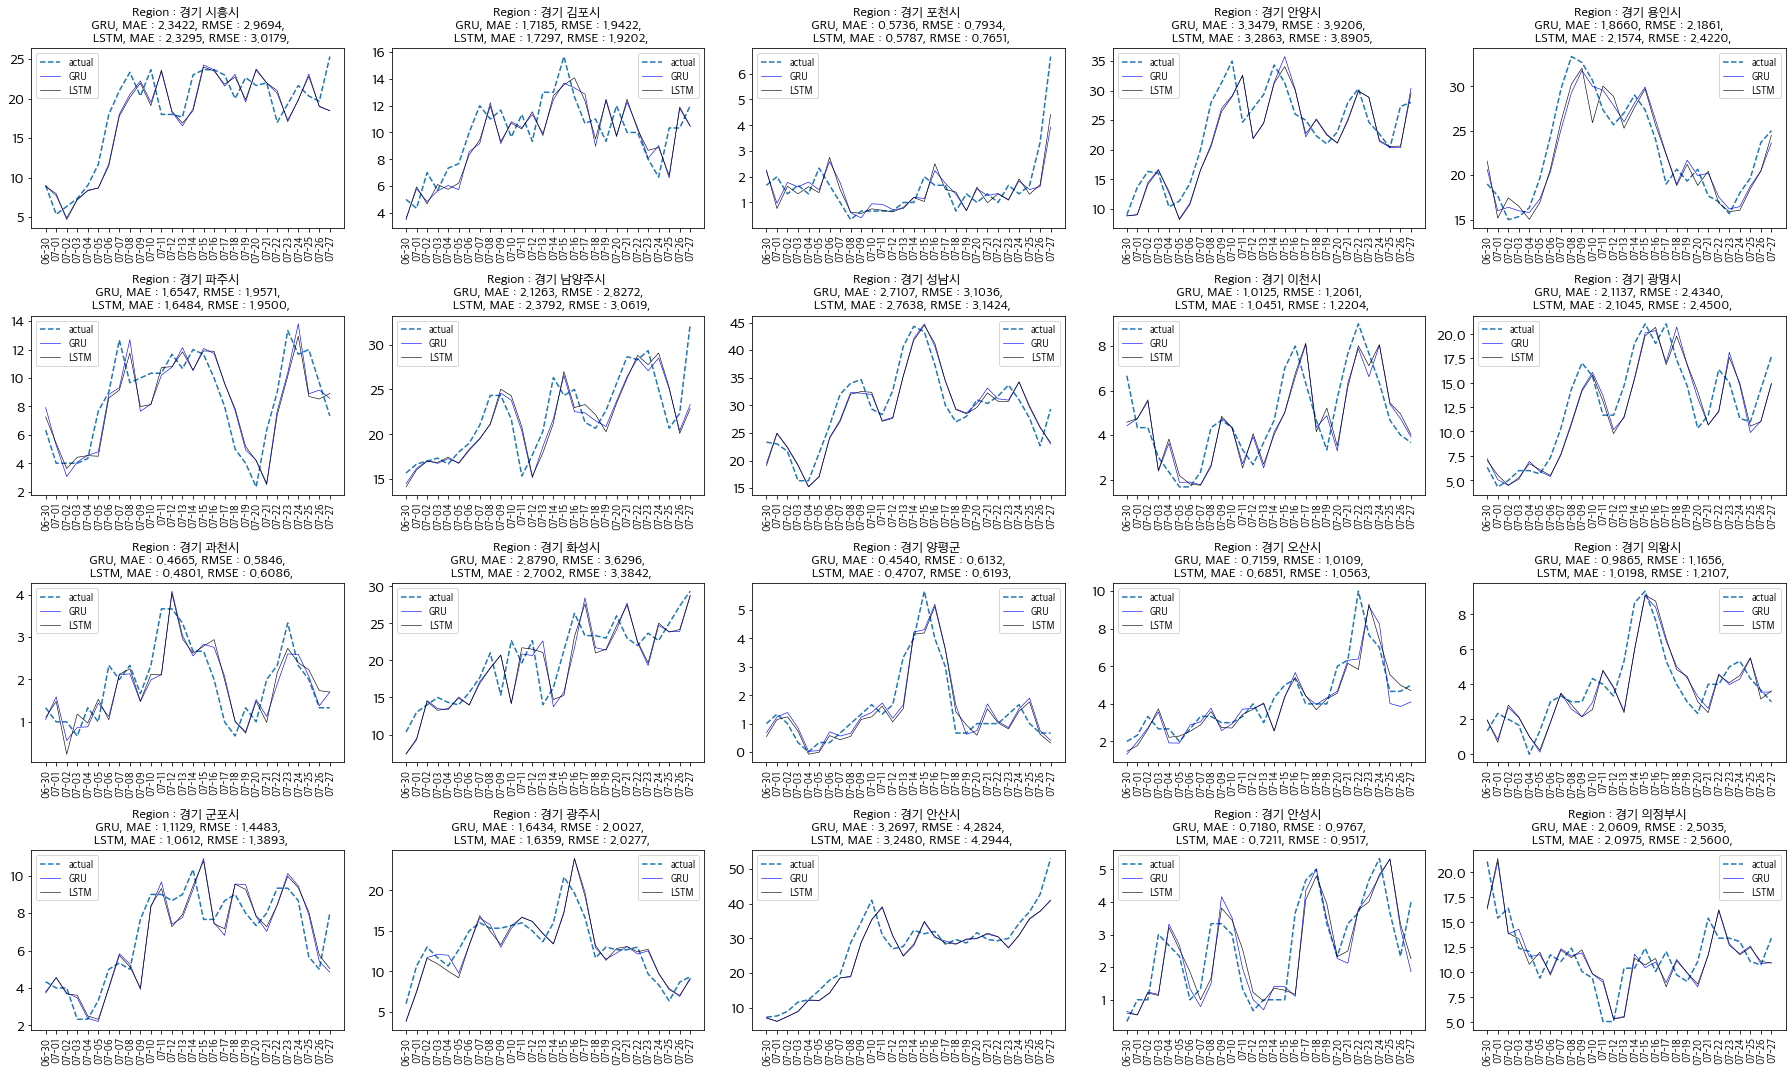

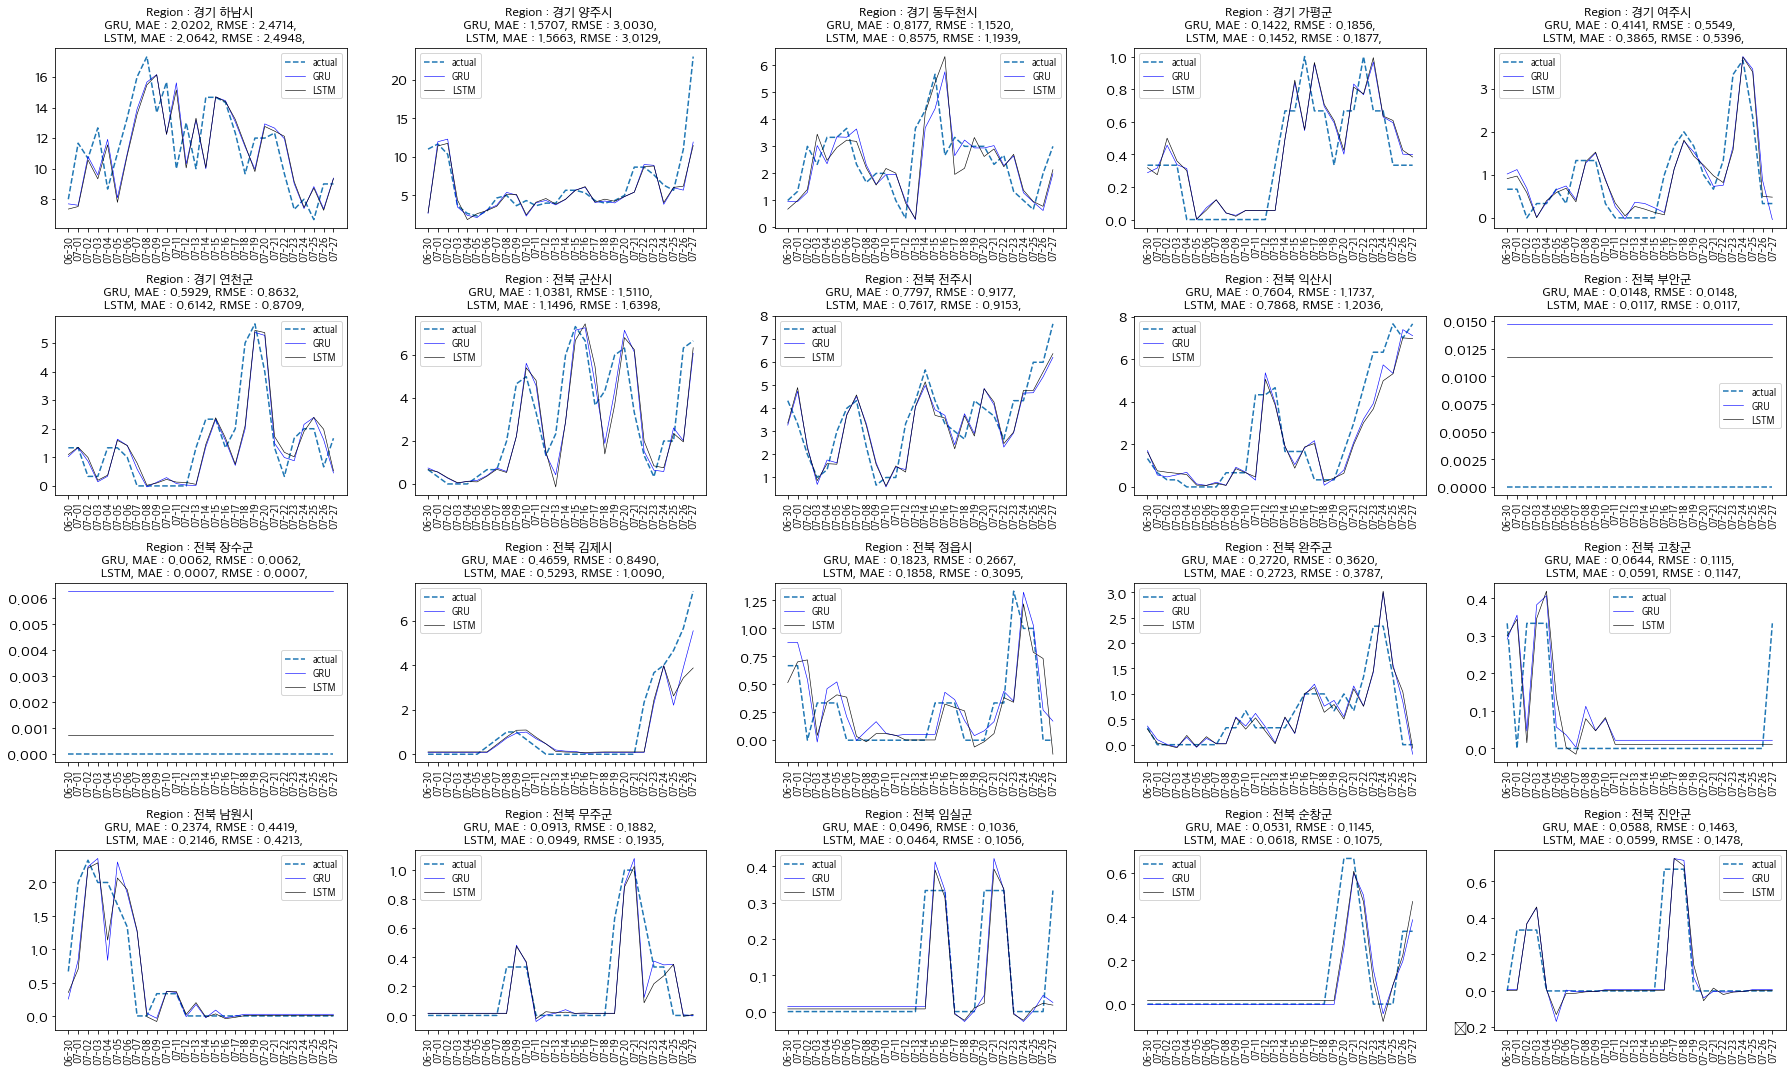

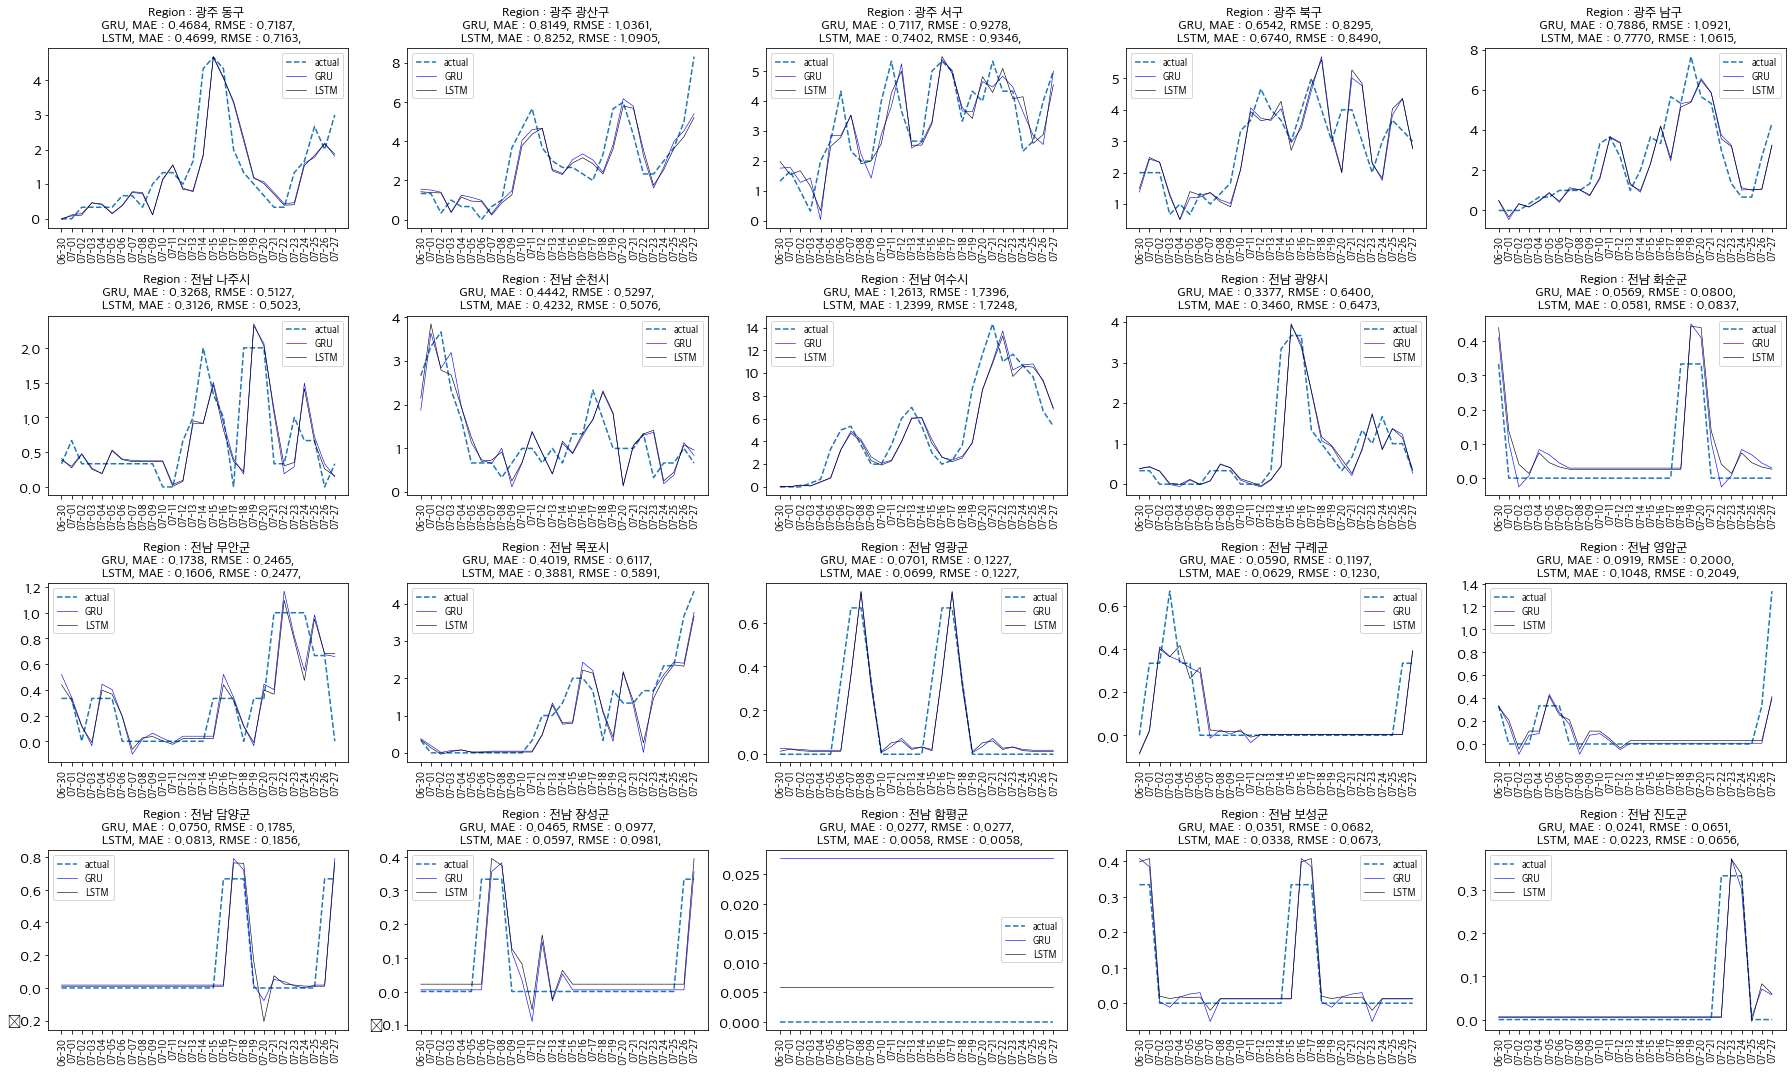

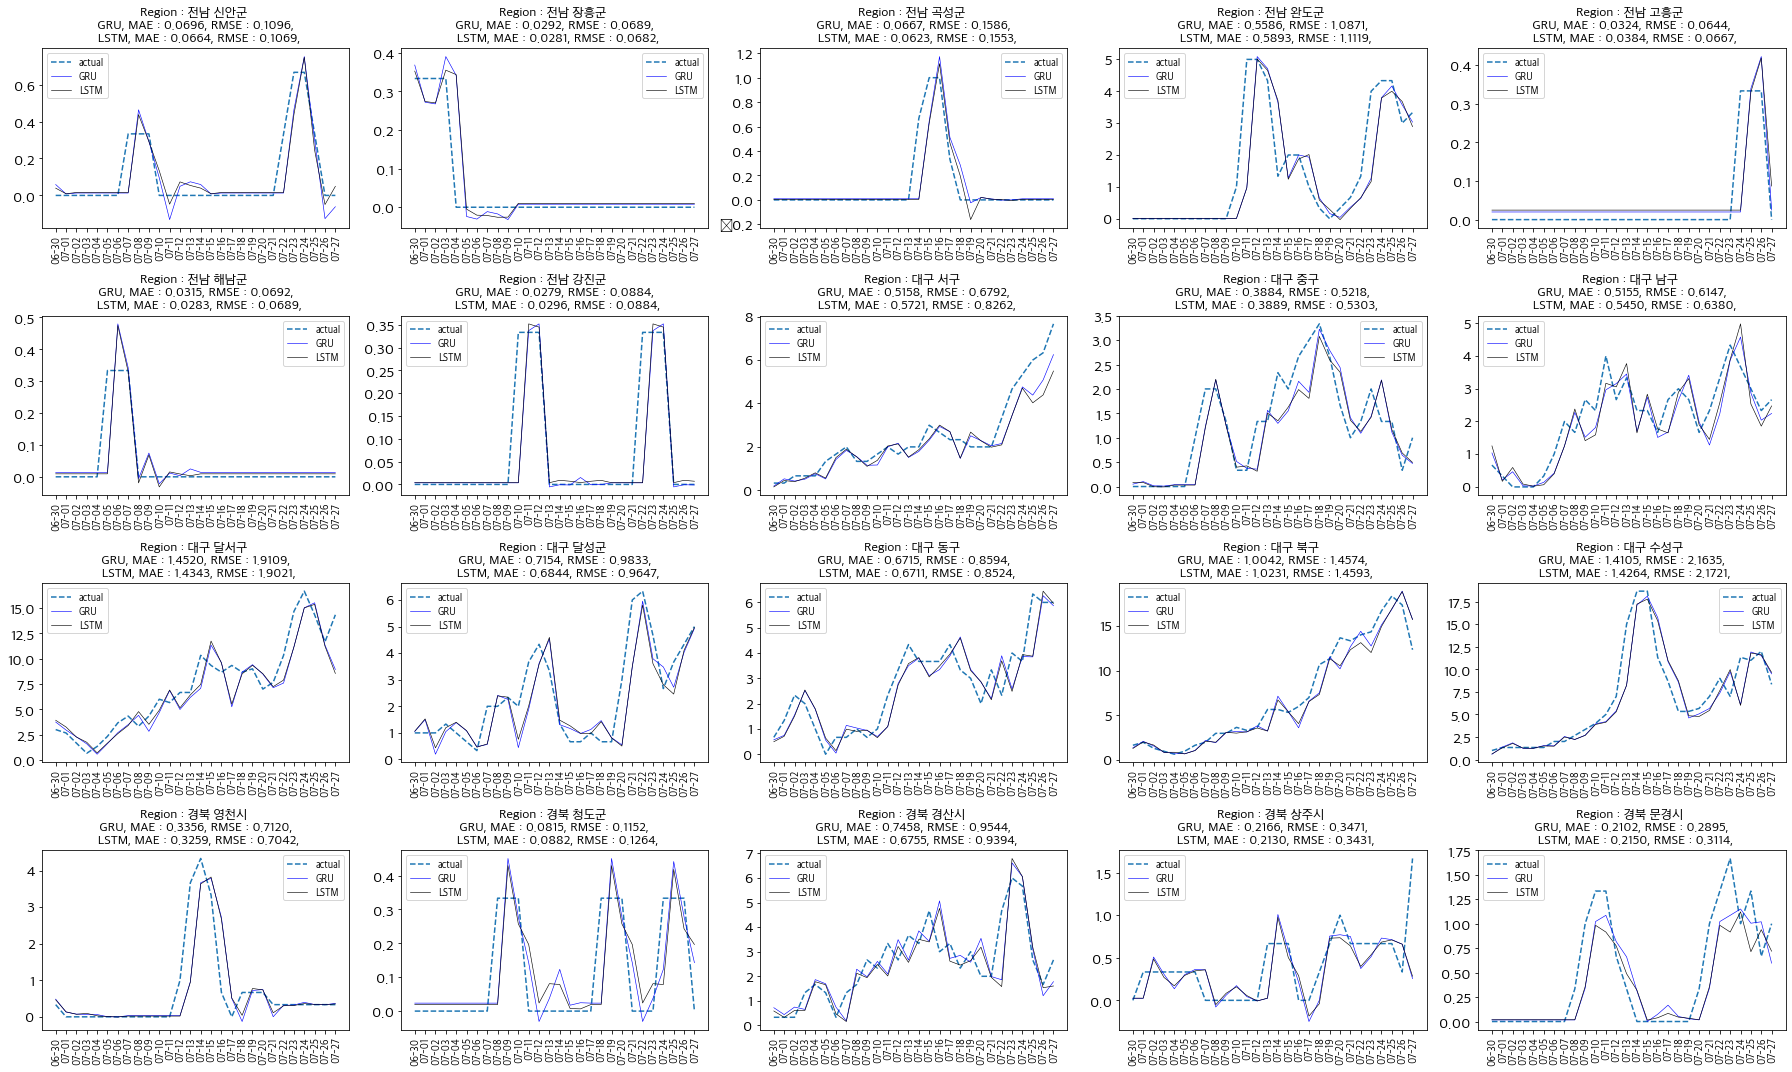

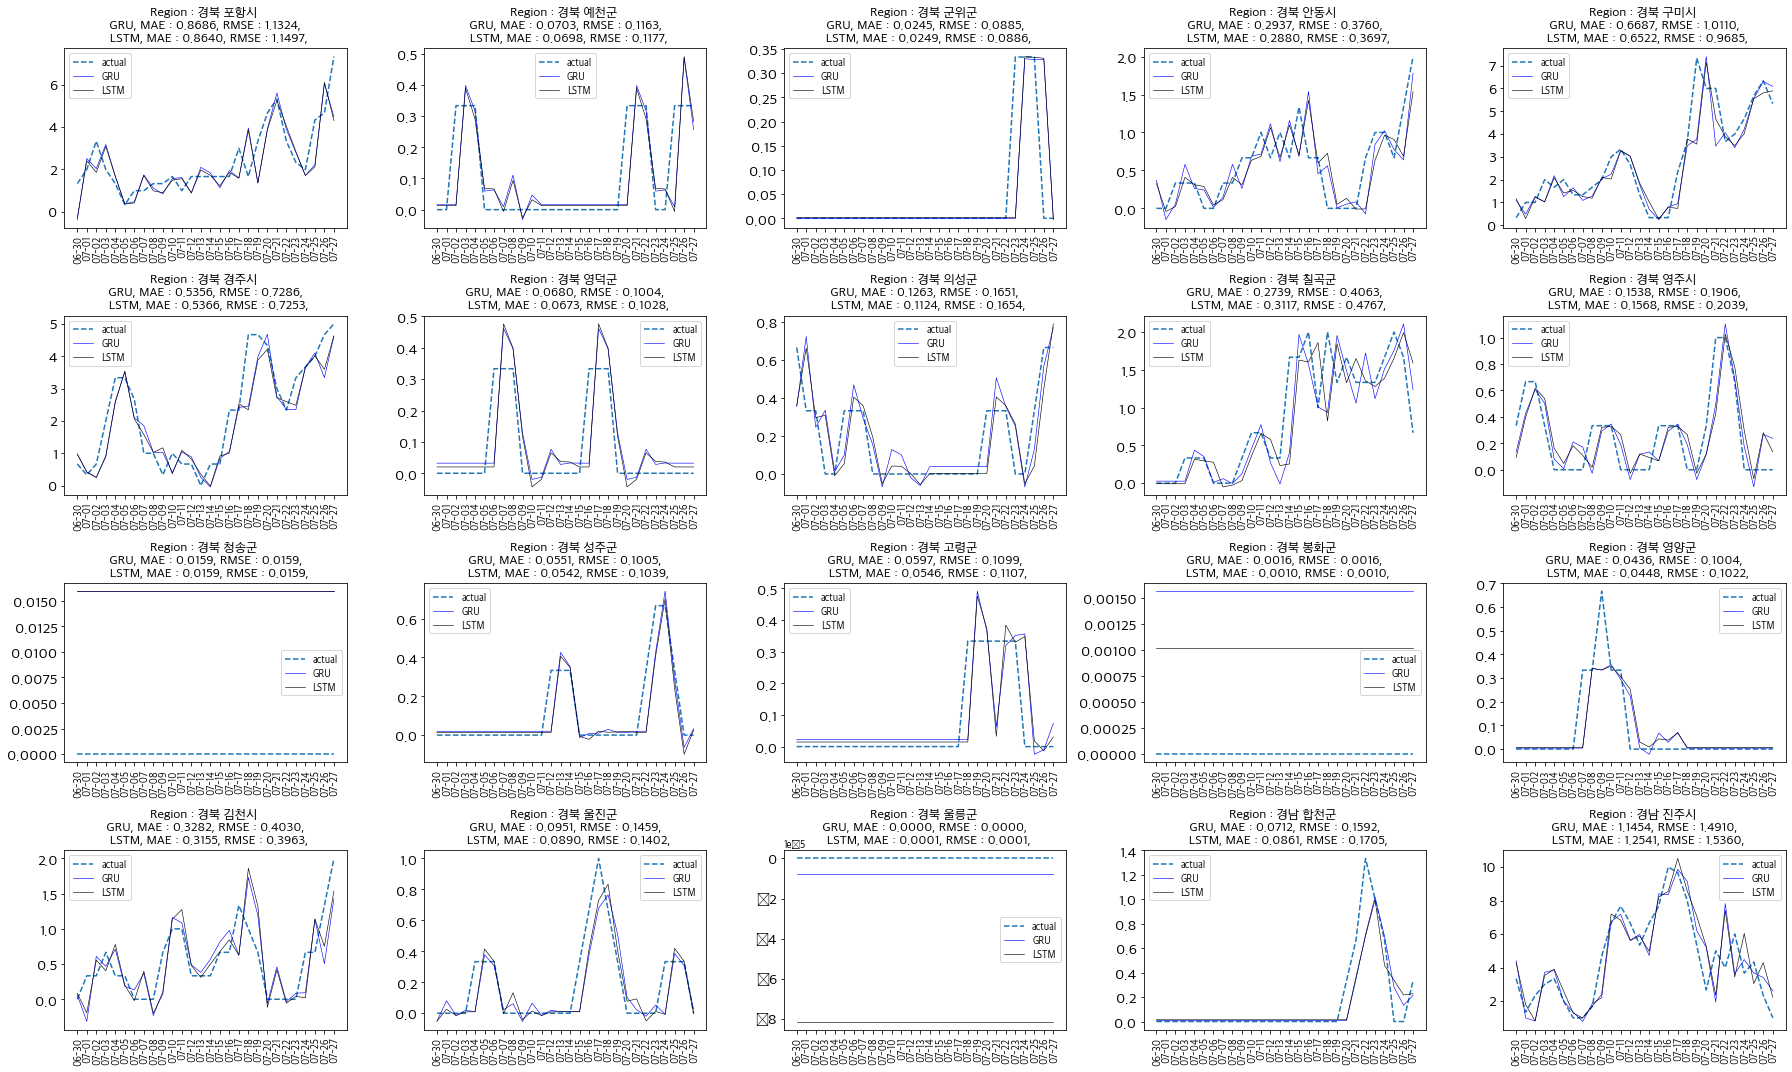

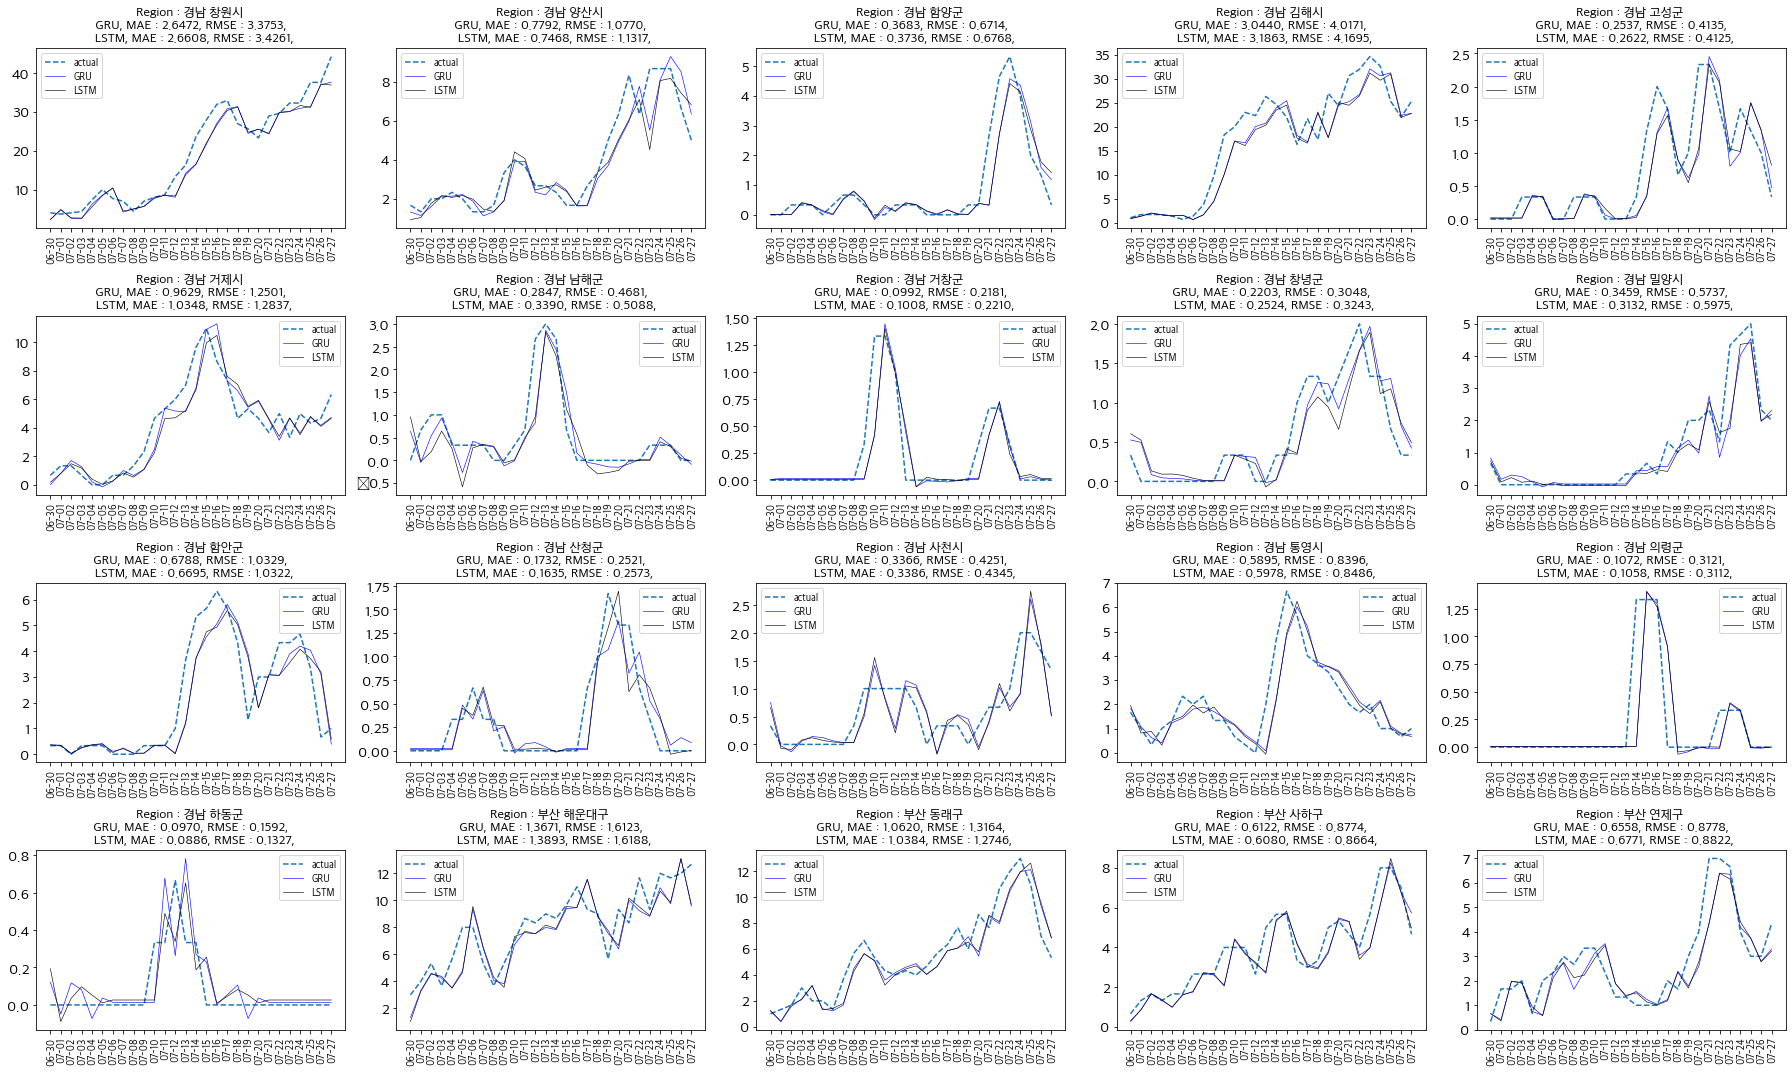

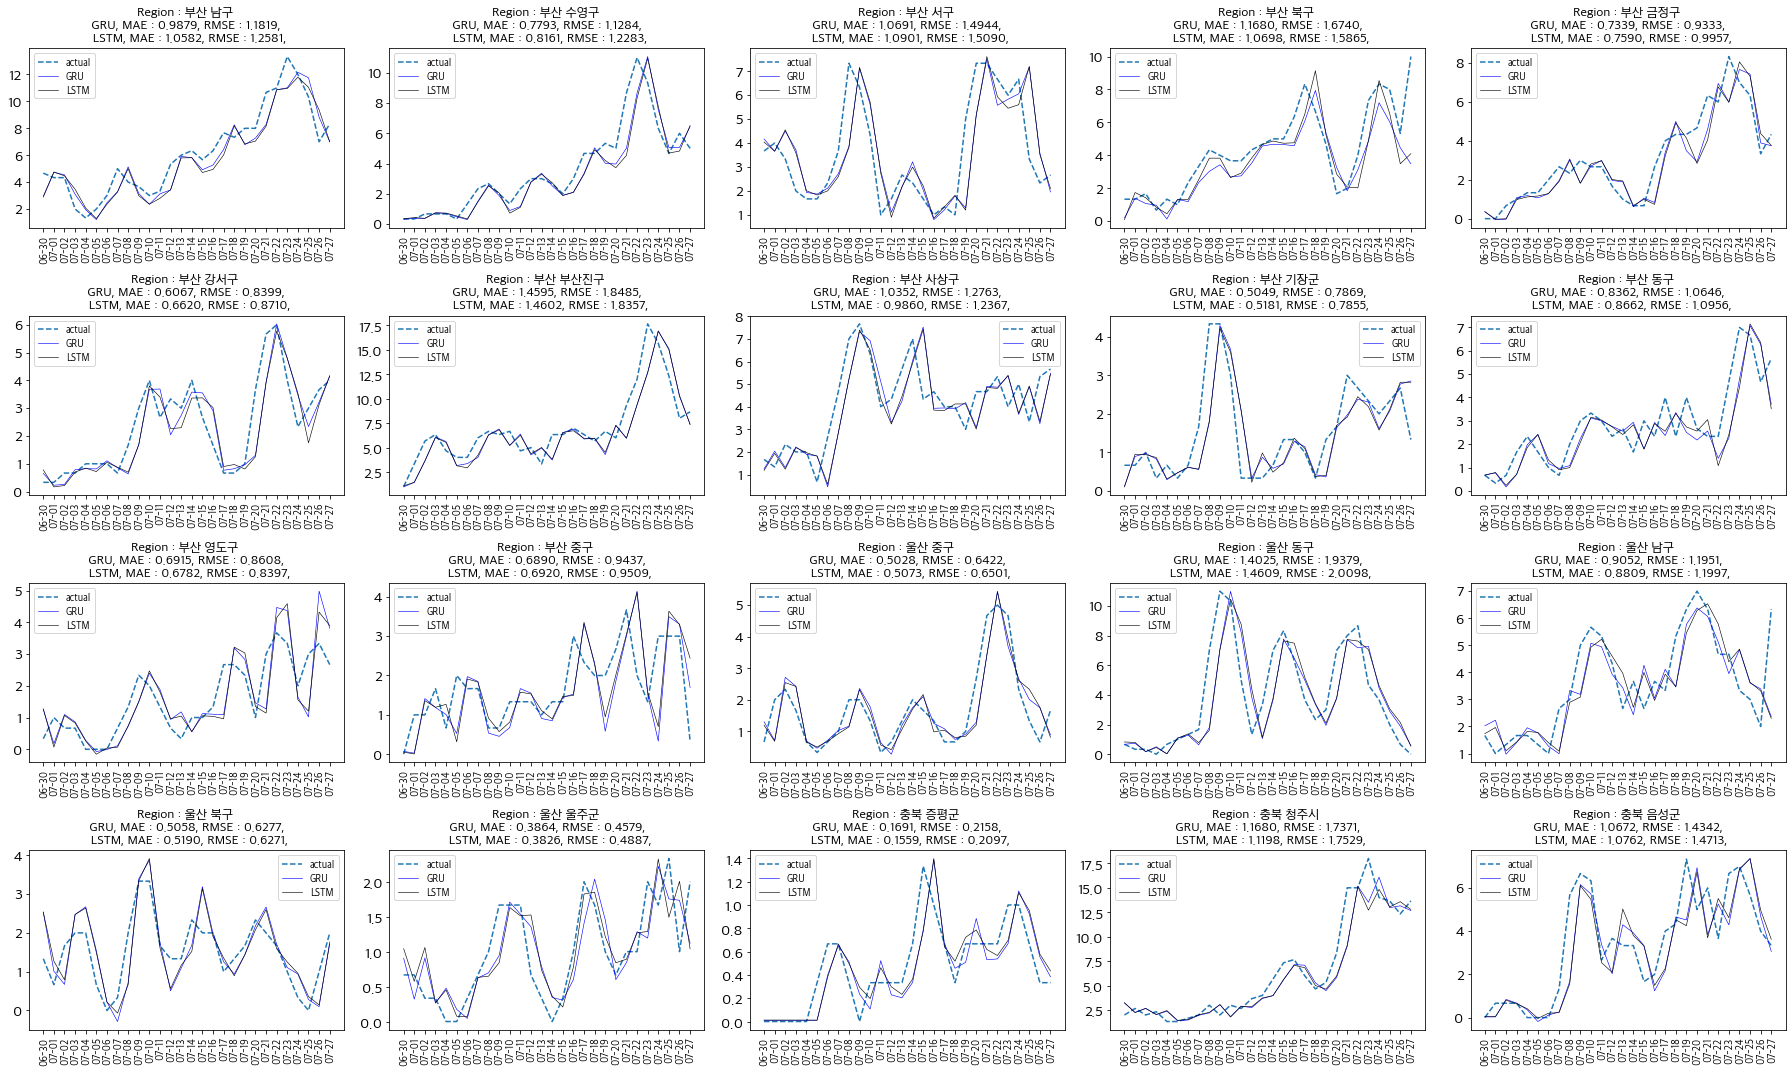

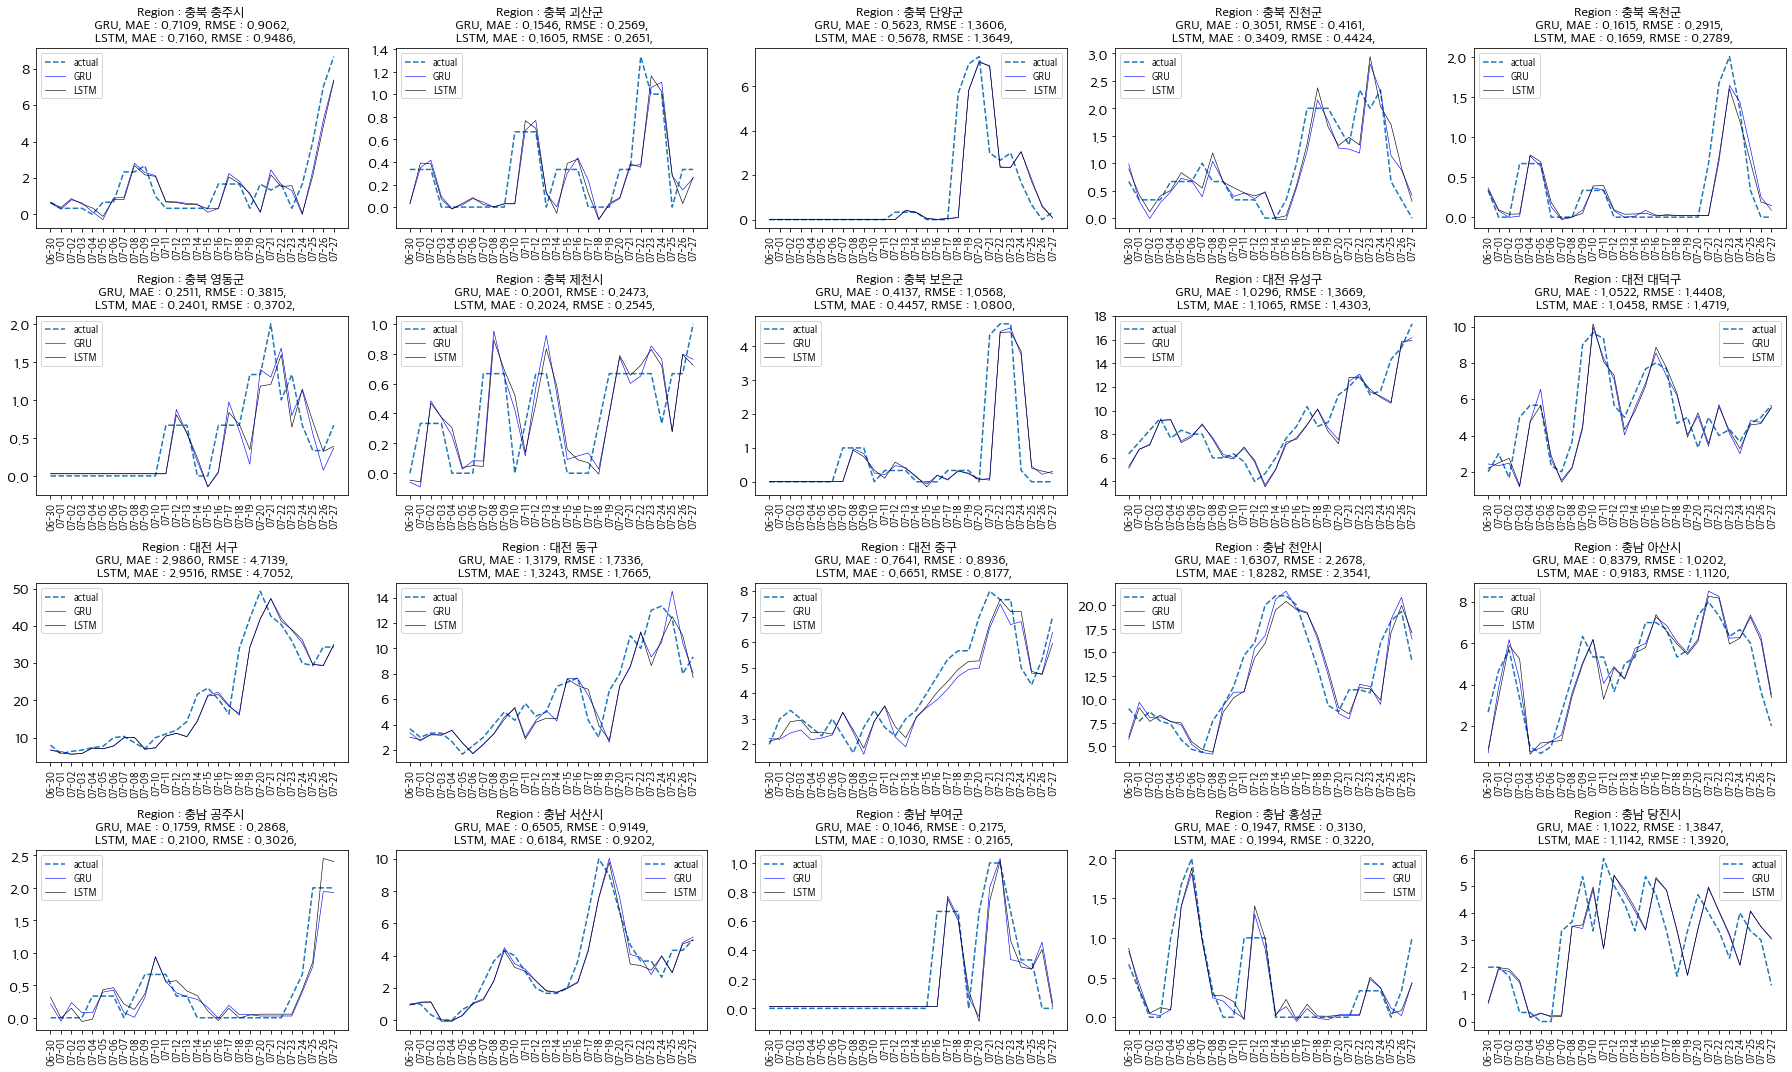

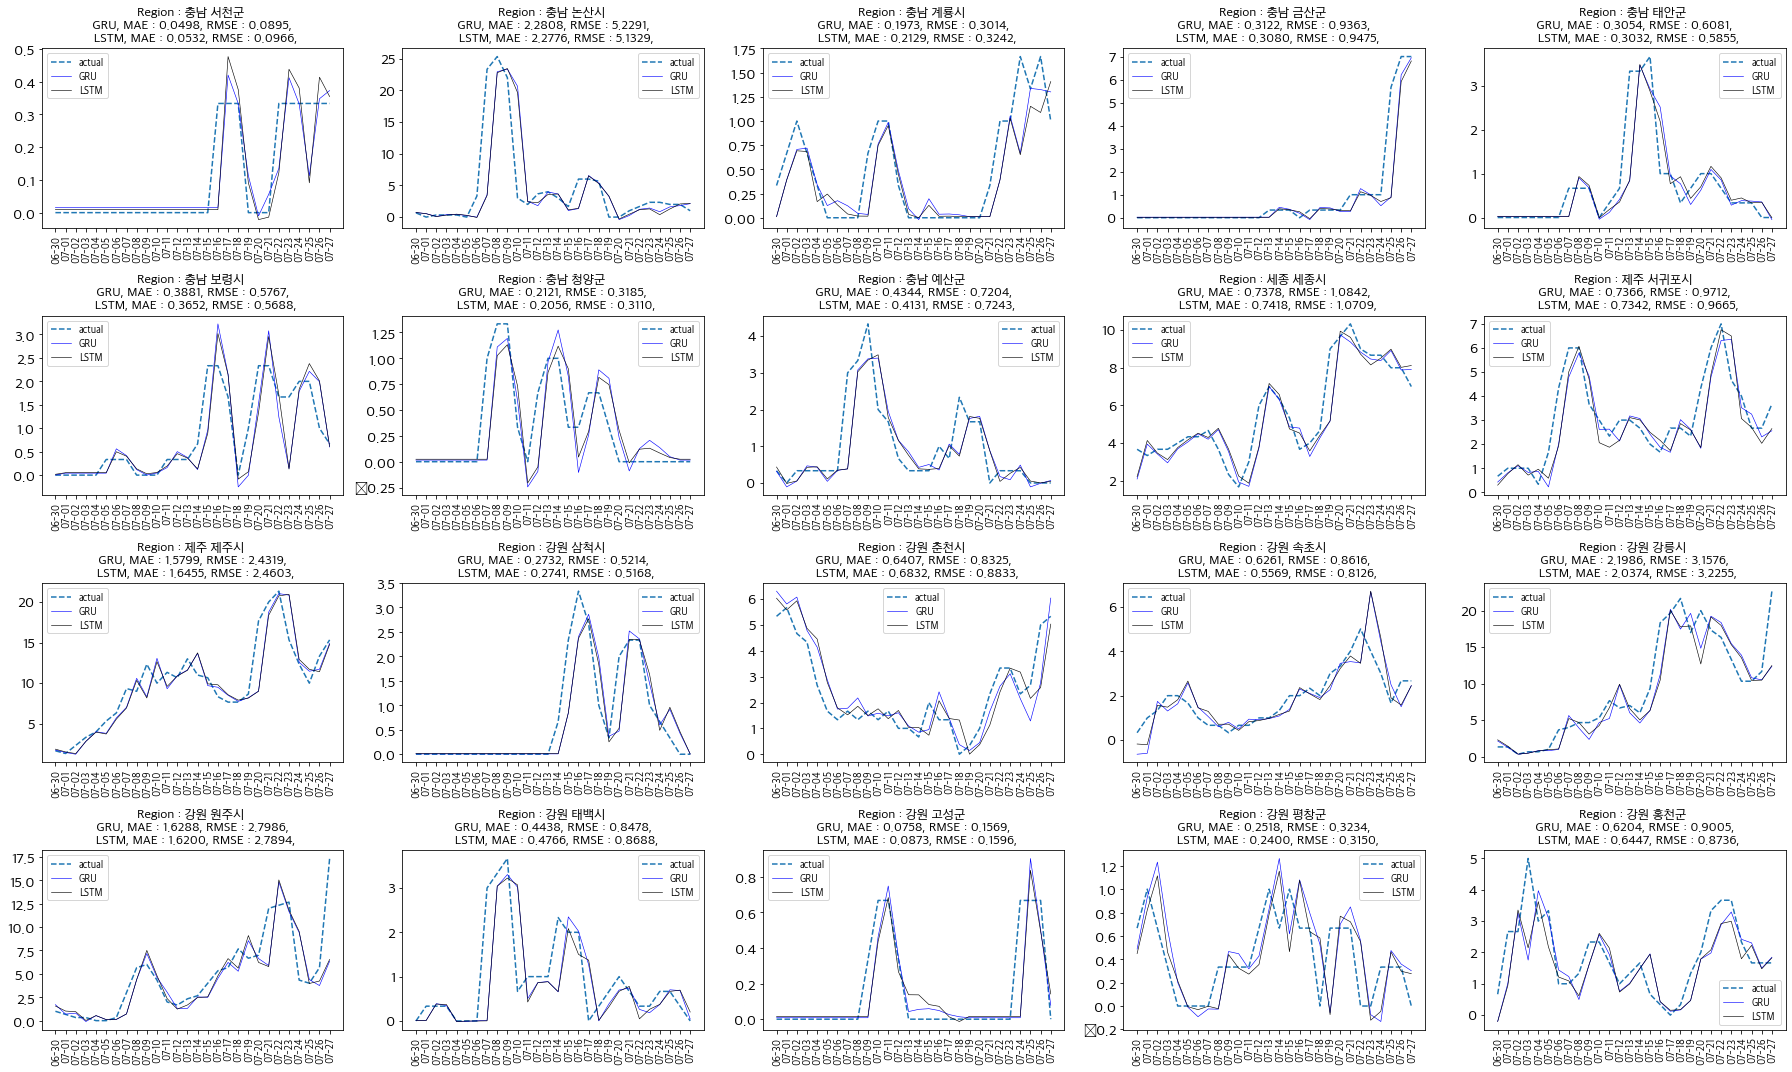

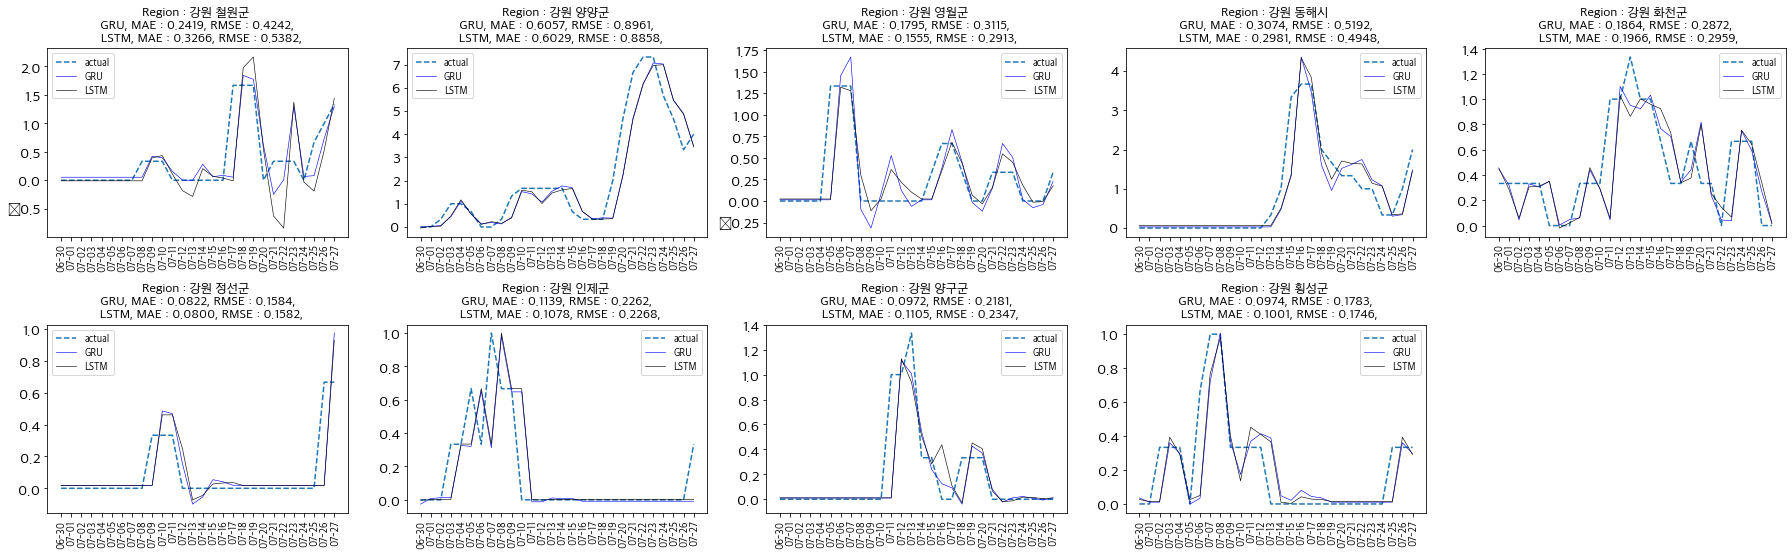

In [17]:
##################
## Load Dataset ##
##################

region_type = 'city'
df2 = pd.read_csv(f'/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/KCDC_data/Processing_Results/smoothing_3_{region_type}_mean.csv', index_col=0, encoding='cp949')

df = df2.iloc[100:554] # 델타 : 554, 540, 533 오미크론 : 707, 693, 686 
df2 = df2.iloc[100:554] 

df = df.diff()
df = df.iloc[1:, :]

# split_date = '2021-11-25'
split_date = '2021-06-25'
val_ratio = 0.2

train_df = df[df.index < split_date]
test = df.iloc[len(train_df):, :]

len_val = int(train_df.shape[0] * val_ratio)
len_train = train_df.shape[0] - len_val
train = train_df.iloc[:len_train,:]
val = train_df.iloc[len_train :, :]


### 컬럼을 숫자로 바꿔줌 ###
# region_dict = {}
# for i, region in enumerate(df.columns):
#     region_dict[i] = region
# df.columns = list(region_dict.keys())

############################################
## train, test, validation length setting ##
############################################

save_GRU = pd.DataFrame({})
save_LSTM = pd.DataFrame({})
fig = plt.figure(figsize=(25,15), facecolor='white')
true_df2 = []
pred_1_list = []
pred_2_list = []

############################
## Hyperparameter Setting ##
############################

suptitle_1 = 'Standard Scaler, GRU'
suptitle_2 = 'Standard Scaler, LSTM'
epochs = 50
batch_size = 16
num_layers = 2
hidden_size = 32
output_size = 32
sequence_length = 5
learning_rate = 1e-3
criterion = nn.MSELoss()

MAE_GRU_list, RMSE_GRU_list, MAE_LSTM_list, RMSE_LSTM_list = [], [], [], []
# date_split = f"{df.index[0]} ~ {df.index[len_train]} ~ {df.index[len_train + len_val]} ~ {df.index[-1]}"
# print(date_split)
# for i in [0]:
for i, region in enumerate(df.columns):
    
    #######################
    ## Define DataLoader ##
    #######################
    
    train = df[[region]][:len_train]
    val = df[[region]][ len_train: len_train + len_val]
    test = df[[region]][ len_train + len_val:]
    
    scaler = StandardScaler()

    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)

    x_train_seq, y_train_seq = seq_data(train, sequence_length)
    x_val_seq, y_val_seq = seq_data(val, sequence_length)
    x_test_seq, y_test_seq = seq_data(test, sequence_length)
    # print(x_train_seq.shape, x_val_seq.shape, x_test_seq.shape)
    
    date_split = f"{df.index[0]} ~ {df.index[len(x_train_seq)-1]} ~ {df.index[len(x_train_seq)+sequence_length + len(x_val_seq)+sequence_length*2-1]} ~ {df.index[-1]}"
    print(date_split)
    
    # input(" stop ")
    n_test_samples = len(y_test_seq)
    train_torch = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
    val_torch = torch.utils.data.TensorDataset(x_val_seq, y_val_seq)
    test_torch = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_torch, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_torch, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_torch, batch_size=batch_size, shuffle=False)

    save_path_1 = f"save_model/gru_smooth_3_{suptitle_1}_{i}.pt"
    save_path_2 = f"save_model/lstm_smooth_3_{suptitle_2}_{i}.pt"
    
    ############################
    ## Define Model and Train ##
    ############################
    
    model_1 = GRU(input_size = x_train_seq.size(2), # x_train_seq.size() : [train_days, time_steps, channel]
                    hidden_size = hidden_size,
                    sequence_length = sequence_length,
                    num_layers = num_layers,
                    device = device).to(device)
    
    model_2 = LSTM(input_size = x_train_seq.size(2),
                    hidden_size = hidden_size,
                    sequence_length = sequence_length,
                    num_layers = num_layers,
                    device = device).to(device)
    
    optimizer_1 = optim.Adam(model_1.parameters(), lr=learning_rate)
    optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate)
    
    trainer_1 = RNNTrainer(model=model_1,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        # test_loader=test_loader,
                        test_loader=torch.tensor(x_test_seq, dtype=torch.float32), # x_test
                        loss=criterion,
                        optimizer=optimizer_1,
                        scaler=scaler,
                        device=device,
                        save_path=save_path_1,
                        raw_test=df2.iloc[-(n_test_samples + 1):,i].values)

    trainer_2 = RNNTrainer(model=model_2,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        # test_loader=test_loader,
                        test_loader=torch.tensor(x_test_seq, dtype=torch.float32), # x_test
                        loss=criterion,
                        optimizer=optimizer_2,
                        scaler=scaler,
                        device=device,
                        save_path=save_path_2,
                        raw_test=df2.iloc[-(n_test_samples + 1):,i].values)
    
    # val_loss_1, epoch_1 = trainer_1.train(epochs)
    # val_loss_2, epoch_2 = trainer_2.train(epochs)
    pred_1 = trainer_1.predict()
    pred_2 = trainer_2.predict()

    #######################
    ## Calculate Metrics ##
    #######################
    
    true_df2 += df2.iloc[-n_test_samples:,i].tolist()
    pred_1_list += list(pred_1)
    pred_2_list += list(pred_2)
    
    # df2를 다 머지하고, pred_1도 다 머지하고
    
    RMSE_GRU, RMSE_total_GRU = compute_metrics(df2.iloc[-n_test_samples:,i], pred_1, metric='rmse')
    MAE_GRU, MAE_total_GRU = compute_metrics(df2.iloc[-n_test_samples:,i], pred_1, metric='mae')
    MAPE_GRU, MAPE_total_GRU = compute_metrics(df2.iloc[-n_test_samples:,i], pred_1, metric='mape')
    
    RMSE_LSTM, RMSE_total_LSTM = compute_metrics(df2.iloc[-n_test_samples:,i], pred_2, metric='rmse')
    MAE_LSTM, MAE_total_LSTM = compute_metrics(df2.iloc[-n_test_samples:,i], pred_2, metric='mae')
    MAPE_LSTM, MAPE_total_LSTM = compute_metrics(df2.iloc[-n_test_samples:,i], pred_2, metric='mape')
    
    ##########################
    ## Original Data Figure ##
    ##########################

    save_GRU[region] = pred_1
    save_LSTM[region] = pred_2
    
    
    if i == 20 * ceil(i/20):
        fig.savefig(f'Result/Figures/compare_rnn_original_{region_type}_{ceil(i/20)}.png')
        fig = plt.figure(figsize=(25,15), facecolor='white')
        # print(i)
    
    if i<20:
        print('make subplot')
        fig.add_subplot(4,5,i+1)
    elif i<40:
        print('make subplot')
        fig.add_subplot(4,5,i-19)
    elif i<60:
        print('make subplot')
        fig.add_subplot(4,5,i-39)
    elif i<80:
        print('make subplot')
        fig.add_subplot(4,5,i-59)
    elif i<100:
        print('make subplot')
        fig.add_subplot(4,5,i-79)
    elif i<120:
        print('make subplot')
        fig.add_subplot(4,5,i-99)
    elif i<140:
        print('make subplot')
        fig.add_subplot(4,5,i-119)
    elif i<160:
        print('make subplot')
        fig.add_subplot(4,5,i-139)
    elif i<180:
        print('make subplot')
        fig.add_subplot(4,5,i-159)
    elif i<200:
        print('make subplot')
        fig.add_subplot(4,5,i-179)
    elif i<220:
        print('make subplot')
        fig.add_subplot(4,5,i-199)
    elif i<240:
        print('make subplot')
        fig.add_subplot(4,5,i-219)
        
    
    
    plt.plot(df2.iloc[-n_test_samples:,i].values,'--')
    print(2)
    plt.plot(pred_1,'b',linewidth=0.6)
    plt.plot(pred_2,'k',linewidth=0.6)
    plt.legend(['actual', 'GRU', 'LSTM'])
    
    # 5: -> yyyy-mm-dd -> mm-dd
    xlabels = [i[5:] for i in list(df2.index[-n_test_samples:])]
    plt.xticks(ticks = [i for i in range(len(xlabels))], labels = xlabels, rotation=90)
    # yticks_ = plt.get_yticks()
    plt.yticks(fontsize = 15)
    
    title_ = 'Region : {} \n GRU, MAE : {:.4f}, RMSE : {:.4f}, \n  LSTM, MAE : {:.4f}, RMSE : {:.4f},'
    title_ = title_.format(region,
                        MAE_GRU.item(),RMSE_GRU.item(),
                        MAE_LSTM.item(),RMSE_LSTM.item(),
                        )
    plt.title(title_ ,fontsize = 13)
    
    MAE_GRU_list.append(MAE_GRU.item())
    RMSE_GRU_list.append(RMSE_GRU.item())
    
    MAE_LSTM_list.append(MAE_LSTM.item())
    RMSE_LSTM_list.append(RMSE_LSTM.item())
    
    
    #################
    ## Save Figure ##
    #################
    # suptitle = f"MAE : {MAE_avg_GRU:.4f}, MAPE : {MAPE_avg_GRU:.4f}, RMSE : {RMSE_avg_GRU:.4f} \n MAE : {MAE_avg_LSTM:.4f}, MAPE : {MAPE_avg_LSTM:.4f}, RMSE : {RMSE_avg_LSTM:.4f}"
    # fig.suptitle(suptitle, fontsize=30)
    fig.tight_layout()
    
    
    # if i == 20 * ceil((i+1)/20):
    #     print('savefig')

true_df2 = np.array(true_df2).reshape(-1,)
pred_1_list = np.array(pred_1_list).reshape(-1,)
pred_2_list = np.array(pred_2_list).reshape(-1,)

_, RMSE_avg_GRU = compute_metrics(true_df2, pred_1_list, metric='rmse')
_, MAE_avg_GRU = compute_metrics(true_df2, pred_1_list, metric='mae')
_, MAPE_avg_GRU = compute_metrics(true_df2, pred_1_list, metric='mape')

_, RMSE_avg_LSTM = compute_metrics(true_df2, pred_2_list, metric='rmse')
_, MAE_avg_LSTM = compute_metrics(true_df2, pred_2_list, metric='mae')
_, MAPE_avg_LSTM = compute_metrics(true_df2, pred_2_list, metric='mape')

#####################
## Save Prediction ##
#####################

# Save for Total Metric of Each Metric
pd.DataFrame({'MAE_GRU' : MAE_GRU_list,
              'RMSE_GRU' : RMSE_GRU_list,
              'MAE_LSTM' : MAE_LSTM_list,
              'RMSE_LSTM' : MAE_LSTM_list
              }, index=df.columns).to_csv(f'Result/summary/RNN_region_metric.csv', encoding='cp949')

pd.DataFrame({'MAE_total' : [MAE_avg_GRU, MAE_avg_LSTM],
              'MAPE_total' : [MAPE_avg_GRU, MAPE_avg_LSTM],
              'RMSE_total' : [RMSE_avg_GRU, RMSE_avg_LSTM],
              }, index=['GRU', 'LSTM']).to_csv(f'Result/summary/RNN_total_metric.csv', encoding='cp949')

save_GRU['신고일'] = df2.index[-n_test_samples:]
save_GRU.set_index('신고일', inplace=True)
save_GRU.to_csv(f'Result/pred/pred_GRU_{region_type}.csv', encoding='cp949')
save_LSTM['신고일'] = df2.index[-n_test_samples:]
save_LSTM.set_index('신고일', inplace=True)
save_LSTM.to_csv(f'Result/pred/pred_LSTM_{region_type}.csv', encoding='cp949')

In [12]:
MAE_total_GRU, RMSE_total_GRU

(0.0939606848904597, 0.1654233154425481)

In [14]:
len(df2.iloc[-n_test_samples:,i]), len(pred_1)

(28, 28)

In [15]:
len(true_df2), len(pred_1_list)

(28, 28)

In [16]:
pred_1_list

array([ 654.0804539 ,  730.24079402,  754.90540048,  715.86230176,
        707.08496721,  692.3927152 ,  794.50787531,  973.34865662,
       1149.04635363, 1224.23514381, 1265.07765599, 1233.47825146,
       1153.42574437, 1187.93461794, 1356.2378715 , 1514.79166147,
       1500.77485044, 1409.95573682, 1375.07522389, 1312.52423852,
       1391.33979947, 1500.69648316, 1606.55288269, 1548.57347857,
       1524.55557046, 1475.80468168, 1380.07553036, 1404.91677542])

In [18]:
true_df2

array([ 736.        ,  768.33333333,  767.        ,  731.66666667,
        690.66666667,  777.33333333,  937.        , 1166.66666667,
       1284.33333333, 1341.66666667, 1286.66666667, 1190.33333333,
       1190.        , 1325.        , 1497.        , 1550.        ,
       1496.33333333, 1416.33333333, 1321.        , 1384.66666667,
       1483.33333333, 1623.        , 1604.66666667, 1605.        ,
       1497.66666667, 1413.66666667, 1395.33333333, 1572.33333333])

In [8]:
0.1 * 0.7885 / 0.2, 0.1 * 0.6931 / 0.2

(0.39425, 0.34655)

In [10]:
(0.7885*0.1 + 0.1*0.6931)/0.2

0.7408